In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image

In [2]:
moving_files_dates = []
sleeping_files_dates = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/move/'):
    moving_files_dates.append(f[:6])
    
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/sleep/'):
    sleeping_files_dates.append(f[:6])

In [3]:
import pandas as pd
df_move = pd.DataFrame({'dates':moving_files_dates})
df_sleep = pd.DataFrame({'dates':sleeping_files_dates})

In [4]:
df_move.value_counts()

dates 
180327    1553
180330     808
180329     231
dtype: int64

In [5]:
df_sleep.value_counts()

dates 
180327    1184
180330     966
180329     885
dtype: int64

# Making Datasets

In [6]:
moving_files_train = []
moving_files_val = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/move/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/move/'+f).shape[0] == 100:
        x = np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/move/'+f)
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        win = f.split('_')[3]
        if ('0329' not in f):
            moving_files_train.append((torch.from_numpy(x).unsqueeze(0), torch.Tensor([0]), date, rec, win))
        else:
            moving_files_val.append((torch.from_numpy(x).unsqueeze(0), torch.Tensor([0]), date, rec, win))
        
sleeping_files_train = []
sleeping_files_val = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/sleep/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/sleep/'+f).shape[0] == 100:
        x = np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/sleep/'+f)
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        win = f.split('_')[3]
        if ('0329' not in f):
            sleeping_files_train.append((torch.from_numpy(x).unsqueeze(0), torch.Tensor([1]), date, rec, win))
        else:
            sleeping_files_val.append((torch.from_numpy(x).unsqueeze(0), torch.Tensor([1]), date, rec, win))

In [7]:
len(moving_files_train), len(sleeping_files_train)

(2361, 2150)

In [8]:
len(moving_files_val), len(sleeping_files_val)

(231, 885)

In [9]:
import random
diff_train = len(moving_files_train)-len(sleeping_files_train)
for i in range(diff_train):
    ind = random.randint(0,len(sleeping_files_train)-1)
    x= sleeping_files_train[ind]
    sleeping_files_train.append(x)

In [10]:
len(moving_files_train), len(sleeping_files_train)

(2361, 2361)

In [11]:
moving_files = moving_files_train + moving_files_val
sleeping_files = sleeping_files_train + sleeping_files_val

len(moving_files), len(sleeping_files)

(2592, 3246)

In [12]:
for i in moving_files:
    print(type(i[0]))
    break

<class 'torch.Tensor'>


In [13]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train',moving_files_train=moving_files_train,sleeping_files_train=sleeping_files_train,moving_files_val=moving_files_val,sleeping_files_val=sleeping_files_val):
        if mode == 'train':
            self.all_files = moving_files_train+sleeping_files_train
        elif mode == 'valid':
            self.all_files = moving_files_val+sleeping_files_val
            
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        return self.all_files[idx]

In [14]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')

In [15]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 16, shuffle = False)

In [16]:
for (data, labels, date, rec, win) in train_loader:
    print(type(data))
    break

<class 'torch.Tensor'>


In [17]:
train_loader_check = DataLoader(dataset = train_dataset, batch_size = 1, shuffle = True)
val_loader_check = DataLoader(dataset = valid_dataset, batch_size = 1, shuffle = False)

# Train/Test Functions

In [18]:
input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
def train(loader, epoch):
    model.train()
    batch_losses = []
    preds = []
    labs = []
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device).float()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
            continue
        
        optimizer.zero_grad()
    
        output, conv1, conv2 = model(data)
        loss = criterion(output.reshape(output.shape[0],-1), labels)
        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
        predictions = []
        for o in output:
            if o.item() > .5:
                predictions.append(1)
            else:
                predictions.append(0)
        predictions = np.array(predictions)
        total += labels.size(0)
        correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
        preds.append(predictions.flatten())
        labs.append(labels.flatten().cpu().numpy())
        
    
    epoch_loss = sum(batch_losses)/len(batch_losses)
    accuracy = correct / total
    
    return epoch_loss, accuracy, preds, labs

In [20]:
def test(loader, epoch):
    model.eval()
    batch_losses = []
    preds = []
    labs = []
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            output, conv1, conv2 = model(data)
            loss = criterion(output, labels)
            
            batch_losses.append(loss)
            
            #get accuracy
            predictions = []
            for o in output:
                if o.item() > .5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            predictions = np.array(predictions)
            total += labels.size(0)
            correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
            preds.append(predictions.flatten())
            labs.append(labels.flatten().cpu().numpy())
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        accuracy = correct/total
        
        return epoch_loss, accuracy, preds, labs

In [21]:
def check_wrong_preds(loader, epoch):
    model.eval()
    dates = []
    recordings = []
    windows = []
    labs = []
    preds = []
    losses = []
    data_pts = []
    
    with torch.no_grad():
        for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            output, conv1, conv2 = model(data)
            loss = criterion(output, labels)
            pred = 0
            if output.item() > .5:
                pred = 1 
            
            if labels.item() != pred:
                dates.append(date[0])
                recordings.append(rec[0])
                windows.append(win[0])
                labs.append(labels.item())
                preds.append(pred)
                losses.append(loss.item())
                data_pts.append(data[0][0].cpu().detach().numpy())
                
    return(pd.DataFrame(list(zip(dates, recordings, windows, labs, preds, losses, data_pts)), columns =['dates', 'recordings', 'windows', 'labs', 'preds', 'losses', 'data_pts']))

In [22]:
def check_correct_preds(loader, epoch):
    model.eval()
    dates = []
    recordings = []
    windows = []
    labs = []
    preds = []
    losses = []
    data_pts = []
    
    with torch.no_grad():
        for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            output, conv1, conv2 = model(data)
            loss = criterion(output, labels)
            pred = 0
            if output.item() > .5:
                pred = 1 
            
            if labels.item() == pred:
                dates.append(date[0])
                recordings.append(rec[0])
                windows.append(win[0])
                labs.append(labels.item())
                preds.append(pred)
                losses.append(loss.item())
                data_pts.append(data[0][0].cpu().detach().numpy())
                
    return(pd.DataFrame(list(zip(dates, recordings, windows, labs, preds, losses, data_pts)), columns =['dates', 'recordings', 'windows', 'labs', 'preds', 'losses', 'data_pts']))

# CNN With Dropout Regularization

In [23]:
class CNNsmalldropout(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNNsmalldropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.dropout = nn.Dropout(0.5)
#         self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride = (1,1), padding = (1,1))
#         self.conv4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride = (1,1), padding = (1,1))
#         self.fc1 = nn.Linear(16*10*100, num_classes)
        self.fc1 = nn.Linear(4*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
#         x = relu(self.conv3(x2))
#         x = relu(self.conv4(x))
        x2 = self.dropout(x2)
        x = x2.reshape(x2.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [24]:
model = CNNsmalldropout().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
#     print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
#     print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

# Plot Loss and Accuracy

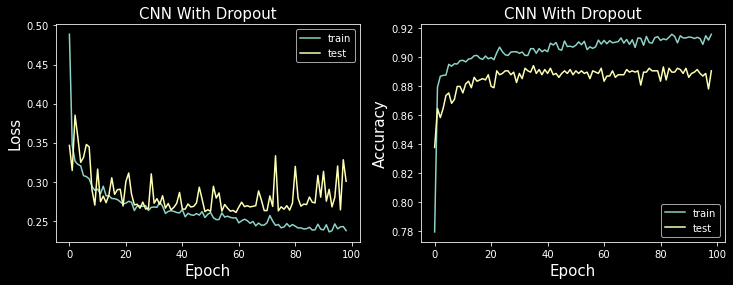

In [38]:
plt.style.use('dark_background')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("CNN With Dropout", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'test')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("CNN With Dropout", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'test')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

# View Weights

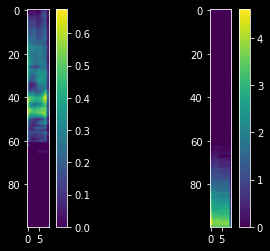

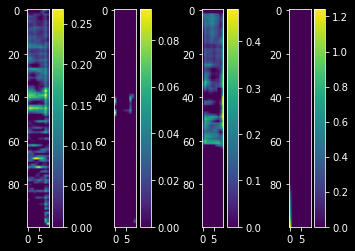

In [26]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, conv1, conv2 = model(data)
    break

weights = conv1[0]
# plt.figure(figsize=(30,90))
for i in range(2):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,2,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

weights = conv2[0]
# plt.figure(figsize=(30,90))
for i in range(4):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,4,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

# Confusion Matrices

In [27]:
predictions_train = np.stack(train_predictions[-1:][0][:-1]).flatten()
labels_train = np.stack(train_labels[-1:][0][:-1]).flatten()

predictions_val = np.stack(validation_predictions[-1:][0][:-1]).flatten()
labels_val = np.stack(validation_labels[-1:][0][:-1]).flatten()

In [28]:
predictions_train = np.concatenate((predictions_train, train_predictions[-1:][0][-1:][0]))
labels_train = np.concatenate((labels_train, train_labels[-1:][0][-1:][0]))

predictions_val = np.concatenate((predictions_val, validation_predictions[-1:][0][-1:][0]))
labels_val = np.concatenate((labels_val, validation_labels[-1:][0][-1:][0]))

In [29]:
df_train = pd.DataFrame({'predictions': predictions_train, 'labels': labels_train})
df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

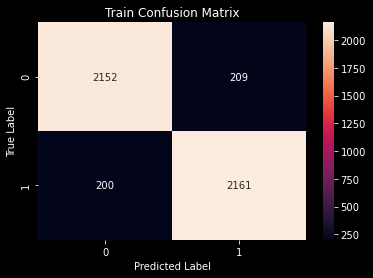

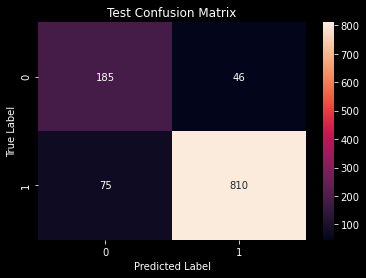

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm_train = confusion_matrix(labels_train, predictions_train)
cm_test = confusion_matrix(labels_val, predictions_val)

ax = plt.axes()
sn.heatmap(cm_train, annot = True, fmt = "d", ax = ax)

ax.set_title('Train Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax)

ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

In [31]:
df_wrong_val = check_wrong_preds(val_loader_check, 0)
df_wrong_val_sorted = df_wrong_val.sort_values(by=['losses'], ascending = False)
df_wrong_val_movement = df_wrong_val_sorted[df_wrong_val_sorted['labs'] == 0.0]
df_wrong_val_nonmovement = df_wrong_val_sorted[df_wrong_val_sorted['labs'] == 1.0]

df_wrong_train = check_wrong_preds(train_loader_check, 0)
df_wrong_train_sorted = df_wrong_train.sort_values(by=['losses'], ascending = False)
df_wrong_train_movement = df_wrong_train_sorted[df_wrong_train_sorted['labs'] == 0.0]
df_wrong_train_nonmovement = df_wrong_train_sorted[df_wrong_train_sorted['labs'] == 1.0]

df_correct_val = check_correct_preds(val_loader_check, 0)
df_correct_val_sorted = df_correct_val.sort_values(by=['losses'], ascending = True)
df_correct_val_movement = df_correct_val_sorted[df_correct_val_sorted['labs'] == 0.0]
df_correct_val_nonmovement = df_correct_val_sorted[df_correct_val_sorted['labs'] == 1.0]

df_correct_train = check_correct_preds(train_loader_check, 0)
df_correct_train_sorted = df_correct_train.sort_values(by=['losses'], ascending = True)
df_correct_train_movement = df_correct_train_sorted[df_correct_train_sorted['labs'] == 0.0]
df_correct_train_nonmovement = df_correct_train_sorted[df_correct_train_sorted['labs'] == 1.0]

# Movement, Validation Set

In [32]:
df_wrong_val_movement[:20]

,dates,recordings,windows,labs,preds,losses,data_pts
23,180329,002,win1,0.0,1,4.076039,"[[0.5322878840597817, 0.5426670538994763, 0.54..."
41,180329,001,win2,0.0,1,2.982533,"[[0.04295253163630177, 0.024597250661660897, 0..."
16,180329,006,win31,0.0,1,2.631672,"[[0.02424385857833587, -0.01911108562881875, -..."
0,180329,002,win0,0.0,1,2.619255,"[[0.27996760283975514, 0.3257456294160055, 0.4..."
8,180329,005,win15,0.0,1,2.543184,"[[-0.015287350331586104, 0.018949444099475358,..."
10,180329,001,win9,0.0,1,2.461117,"[[0.3861271913120223, 0.4217443244992676, 0.26..."
21,180329,005,win18,0.0,1,2.209435,"[[0.21617445945116803, 0.2047013933935751, 0.2..."
43,180329,005,win19,0.0,1,2.089198,"[[0.29909824851704625, 0.2595626298895865, 0.3..."
12,180329,006,win1,0.0,1,2.048460,"[[-0.09874251661417295, -0.10228644752785039, ..."
13,180329,001,win7,0.0,1,1.937286,"[[-0.08882142480100749, -0.08349575774708097, ..."


In [33]:
df_correct_val_movement[:20]

,dates,recordings,windows,labs,preds,losses,data_pts
144,180329,001,win31,0.0,0,0.000000,"[[4.011483949068493, 4.01261497973301, 4.01604..."
18,180329,001,win30,0.0,0,0.000000,"[[0.049448446545001565, 0.14000934616485916, 0..."
52,180329,001,win117,0.0,0,0.000000,"[[2.504828233961095, 2.5305643047477138, 2.539..."
81,180329,001,win124,0.0,0,0.000000,"[[-0.17545485297637897, -0.1302530299406775, -..."
128,180329,001,win110,0.0,0,0.000001,"[[-0.6748032249545175, -0.777800232408688, -0...."
12,180329,001,win125,0.0,0,0.000006,"[[4.676493921331479, 4.681199580534922, 4.6799..."
175,180329,001,win32,0.0,0,0.000023,"[[2.909331352209962, 2.894504356084963, 2.6875..."
74,180329,001,win59,0.0,0,0.000026,"[[-0.2643481303930372, -0.19975211986117014, -..."
56,180329,001,win21,0.0,0,0.001002,"[[1.4561677685312011, 1.4682176104728986, 1.47..."
172,180329,001,win119,0.0,0,0.002208,"[[-0.2537660045222962, -0.3492496584149226, -0..."


Showing from validation set examples where the model incorrectly predicted movement as non-movement


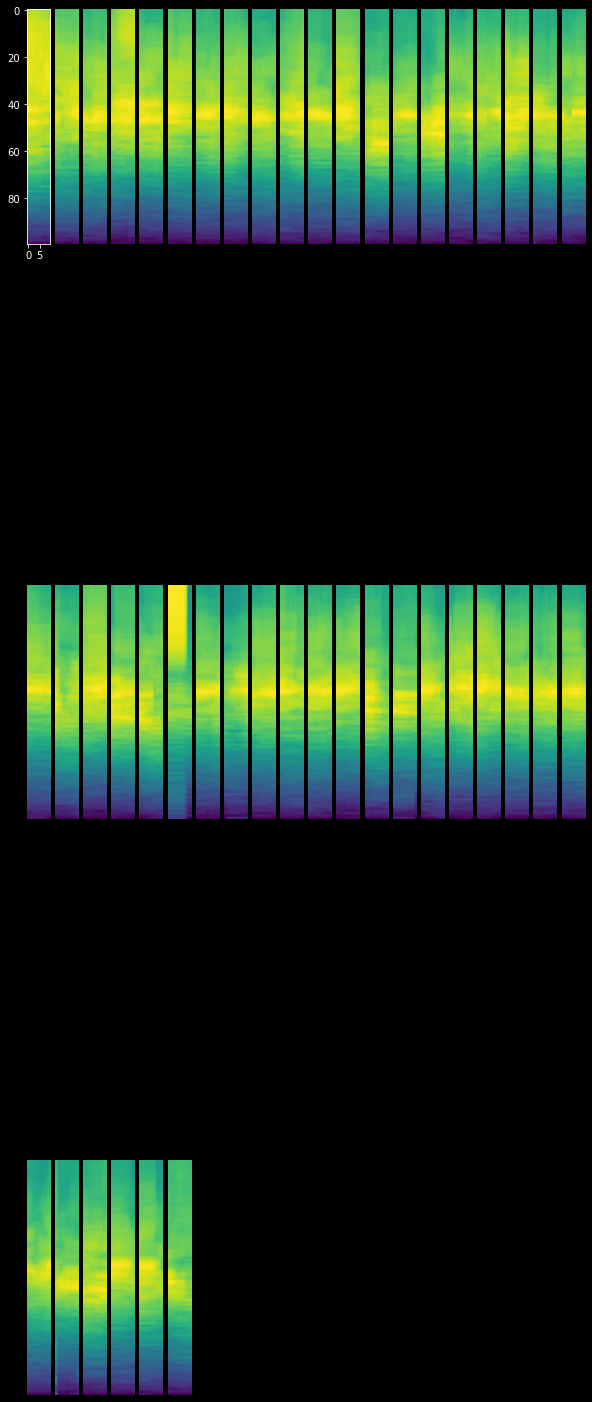

Showing from validation set examples where the model correctly predicted movement


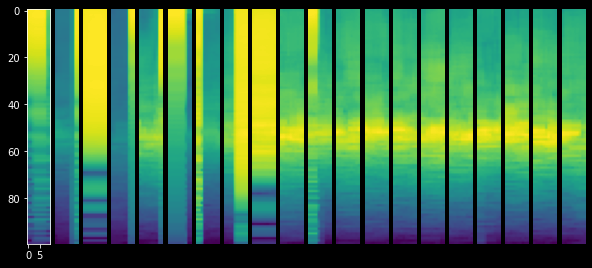

In [39]:
print('Showing from validation set examples where the model incorrectly predicted movement as non-movement')
plt.figure(figsize=(10,30))
for i in range(46):
    d = df_wrong_val_movement.iloc[i]['data_pts']
    plt.subplot(3,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

print('Showing from validation set examples where the model correctly predicted movement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_correct_val_movement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

# NonMovement, Validation Set

Showing from validation set examples where the model incorrectly predicted nonmovement as movement


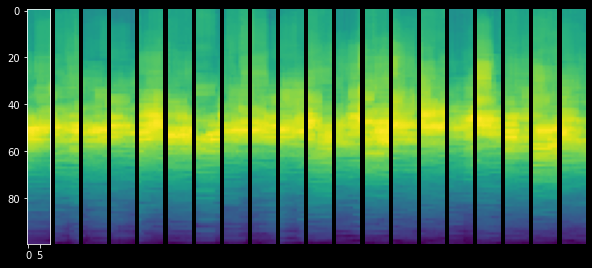

Showing from validation set examples where the model correctly predicted nonmovement


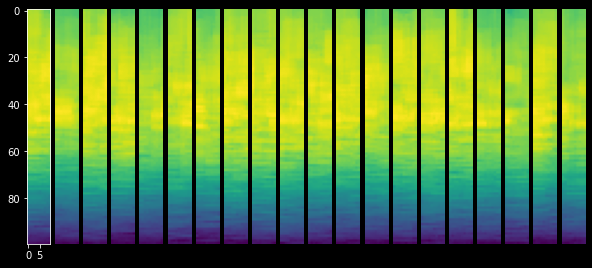

In [35]:
print('Showing from validation set examples where the model incorrectly predicted nonmovement as movement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_wrong_val_nonmovement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

print('Showing from validation set examples where the model correctly predicted nonmovement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_correct_val_nonmovement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

# Movement, Training Set

Showing from train set examples where the model incorrectly predicted movement as non-movement


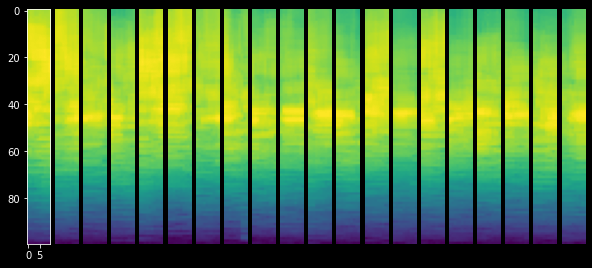

Showing from train set examples where the model correctly predicted movement


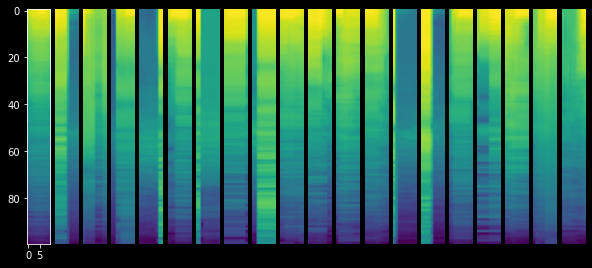

In [36]:
print('Showing from train set examples where the model incorrectly predicted movement as non-movement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_wrong_train_movement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

print('Showing from train set examples where the model correctly predicted movement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_correct_train_movement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

# Nonmovement, Training Set

Showing from train set examples where the model incorrectly predicted nonmovement as movement


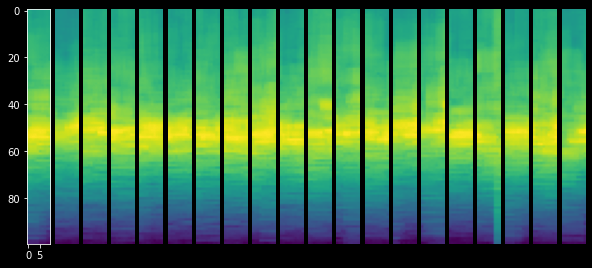

Showing from train set examples where the model correctly predicted nonmovement


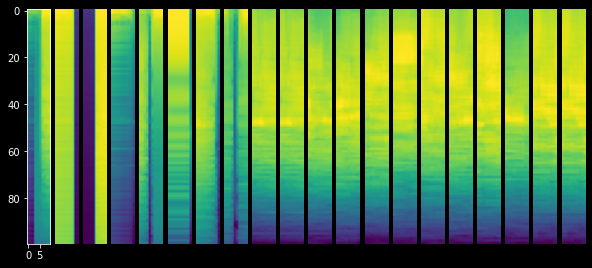

In [37]:
print('Showing from train set examples where the model incorrectly predicted nonmovement as movement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_wrong_train_nonmovement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

print('Showing from train set examples where the model correctly predicted nonmovement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_correct_train_nonmovement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()